# Analiza podatkov

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

data = pd.read_excel("data.xlsx")
data.drop(data.filter(regex="Unname"),axis=1, inplace=True)

Nov dataframe ima spol 0 za moske, 1 za zenske, diagnoza 0 neishemicna, 1 ishemicna

--------------------------------------------------------
        Ne potrebujemo, smo naredili bolj elegantno
--------------------------------------------------------
Naredimo encoder za kategorične spremenljivke

In [2]:
"""from sklearn.preprocessing import OneHotEncoder

# Izberimo le kategorične stolpce
categorical_cols = data.columns[data.dtypes=="object"]

# Ustvarimo enkoder za kodiranje
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# Izvedimo kodiranje
OH_cols = OH_encoder.fit_transform(data[categorical_cols])

# Sestavimo dataframe, z enkodiranimi stolpci namesto originalnih
OH_cols = pd.DataFrame(OH_cols, columns = OH_encoder.get_feature_names_out())
OH_cols.index = data.index
numeric_data = data.drop(categorical_cols, axis=1)
data = pd.concat([OH_cols, numeric_data], axis=1)"""

'from sklearn.preprocessing import OneHotEncoder\n\n# Izberimo le kategorične stolpce\ncategorical_cols = data.columns[data.dtypes=="object"]\n\n# Ustvarimo enkoder za kodiranje\nOH_encoder = OneHotEncoder(handle_unknown=\'ignore\', sparse_output=False)\n# Izvedimo kodiranje\nOH_cols = OH_encoder.fit_transform(data[categorical_cols])\n\n# Sestavimo dataframe, z enkodiranimi stolpci namesto originalnih\nOH_cols = pd.DataFrame(OH_cols, columns = OH_encoder.get_feature_names_out())\nOH_cols.index = data.index\nnumeric_data = data.drop(categorical_cols, axis=1)\ndata = pd.concat([OH_cols, numeric_data], axis=1)'

--------------------------------------------------------
        Ne potrebujemo, smo naredili bolj elegantno
--------------------------------------------------------

In [3]:
X = data.drop("responder", axis=1)
y = data["responder"]

In [4]:
from numpy import unique
classes = unique(y)
total = len(y)
for c in classes:
 n_examples = len(y[y==c])
 percent = n_examples / total * 100
 print('> Class=%d : %d/%d (%.1f%%)' % (c, n_examples, total, percent))

> Class=0 : 93/196 (47.4%)
> Class=1 : 103/196 (52.6%)


## Strojno učenje

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import SGDClassifier # Ta bo potreboval tudi pipo s skaliranjem podatkov
from sklearn.preprocessing import StandardScaler
SGDC = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))

from sklearn.ensemble import GradientBoostingClassifier
import lightgbm
from lightgbm import LGBMClassifier
import xgboost
from xgboost import XGBClassifier

In [6]:
#Naredimo pipo za NaN
imputer = SimpleImputer(strategy='mean')

### Accuracy, precision, recall, roc za posamezne modele

In [7]:
import random
random.seed(1)

models = [GaussianNB(), DecisionTreeClassifier(), SVC(), LogisticRegression(max_iter=5000), RandomForestClassifier(), 
          KNeighborsClassifier(), MultinomialNB(force_alpha=True), SGDC, GradientBoostingClassifier(n_estimators=100, learning_rate=1.0), LGBMClassifier(), XGBClassifier()]
names = ["Naive Bayes", "Decision Tree", "SVC", "LogReg", "Random Forest", "KNeighbors", "MNB", "SGDC", "GB", "LGBM", "XGB"]
for model, name in zip(models, names):
    print(name)
    for score in ["accuracy", "precision", "recall", "roc_auc"]:
        regressor = Pipeline(
            steps=[('imputer', imputer), ('regressor', model)]
            )
        print(score, " : ", "%.2f" % cross_val_score(regressor, X, y, scoring=score, cv=5).mean(), " +- ", "%.2f" % cross_val_score(regressor, X, y, scoring=score, cv=5).std())
    print("\n")

Naive Bayes
accuracy  :  0.58  +-  0.04
precision  :  0.57  +-  0.03
recall  :  0.85  +-  0.05
roc_auc  :  0.60  +-  0.07


Decision Tree
accuracy  :  0.54  +-  0.07
precision  :  0.59  +-  0.11
recall  :  0.59  +-  0.01
roc_auc  :  0.57  +-  0.11


SVC
accuracy  :  0.61  +-  0.07
precision  :  0.61  +-  0.07
recall  :  0.75  +-  0.09
roc_auc  :  0.72  +-  0.05


LogReg
accuracy  :  0.60  +-  0.07
precision  :  0.62  +-  0.07
recall  :  0.63  +-  0.15
roc_auc  :  0.59  +-  0.07


Random Forest
accuracy  :  0.60  +-  0.03
precision  :  0.63  +-  0.08
recall  :  0.61  +-  0.08
roc_auc  :  0.64  +-  0.06


KNeighbors
accuracy  :  0.65  +-  0.04
precision  :  0.65  +-  0.05
recall  :  0.73  +-  0.11
roc_auc  :  0.65  +-  0.07


MNB
accuracy  :  0.61  +-  0.08
precision  :  0.61  +-  0.07
recall  :  0.77  +-  0.03
roc_auc  :  0.63  +-  0.08


SGDC
accuracy  :  0.56  +-  0.06
precision  :  0.59  +-  0.04
recall  :  0.55  +-  0.14
roc_auc  :  0.49  +-  0.07


GB
accuracy  :  0.58  +-  0.04
pr

### Feature importance

Vseeno zapolnimo celoten dataset manjkajocih s povprecjem

In [8]:
manjkajoce = X.isnull().sum()
meja = 0.2
for col in X.columns:
    if manjkajoce[col] > 0:
        # Imputiramo manjkajoče vrednosti
        if manjkajoce[col] < len(X)*meja:
            if X[col].dtype == 'float64':
                X[col].fillna(X[col].mean(), inplace=True)
            else:
                X[col].fillna(X[col].mode()[0], inplace=True)
        # ali pa stolpcec zavržemo
        else:
            X.drop(col, axis=1, inplace=True)

In [9]:
from sklearn.model_selection import cross_validate

clf=RandomForestClassifier(n_estimators =10, random_state = 42, class_weight="balanced")

output = cross_validate(clf, X, y, cv=5, scoring = 'accuracy', return_estimator =True)

for idx,estimator in enumerate(output['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = X.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)

Features sorted by their score for estimator 0:
                        importance
kreatinin                 0.104182
pro-BNP                   0.085946
RDW                       0.068730
trigliceridi              0.066203
Razdalja                  0.063801
AF                        0.056986
sečnina                   0.048301
TRC                       0.047080
VTI                       0.044288
LVEDD                     0.043878
gGT                       0.039620
EF                        0.037373
LDL                       0.036111
Hb                        0.032412
glukoza                   0.029129
bilirubin (cel)           0.027923
Holesterol                0.025307
HDL                       0.024203
Na                        0.023534
K                         0.022461
L                         0.020559
AST                       0.020324
CRP                       0.011321
starost                   0.010968
Spol                      0.007484
Glavna_diagnoza           0.001875
transpl

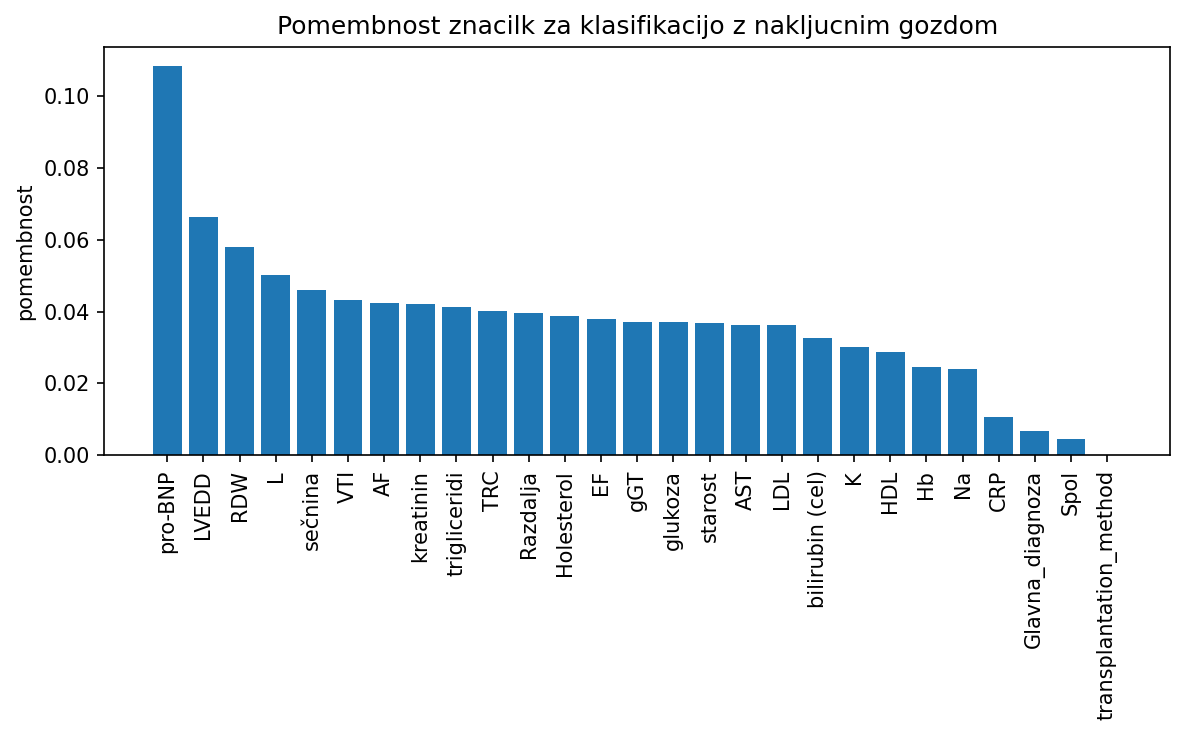

In [10]:
meta_model = RandomForestClassifier(100)
meta_model.fit(X, y)

imena_znacilk = X.columns
koristnost_znacilk = meta_model.feature_importances_
sortind = np.argsort(-koristnost_znacilk)
urejena_koristnost = koristnost_znacilk[sortind]
urejena_imena = imena_znacilk[sortind]

import matplotlib.pyplot as plt

xs = range(len(imena_znacilk))
plt.figure(figsize=(8,5), dpi=150)
plt.bar(xs, urejena_koristnost)
plt.xticks(xs, urejena_imena, rotation='vertical')
plt.ylabel("pomembnost")
plt.title("Pomembnost znacilk za klasifikacijo z nakljucnim gozdom")
plt.tight_layout()
plt.show()

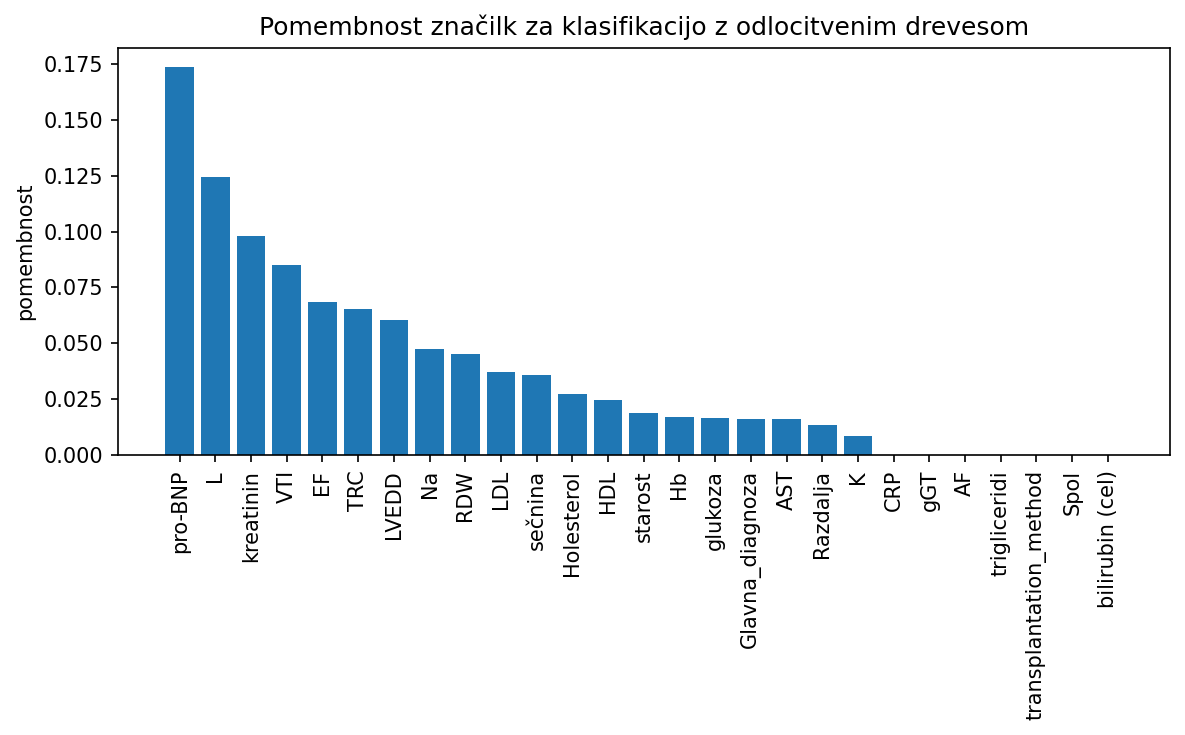

In [11]:
meta_model = DecisionTreeClassifier()
meta_model.fit(X, y)

imena_znacilk = X.columns
koristnost_znacilk = meta_model.feature_importances_
sortind = np.argsort(-koristnost_znacilk)
urejena_koristnost = koristnost_znacilk[sortind]
urejena_imena = imena_znacilk[sortind]

import matplotlib.pyplot as plt

xs = range(len(imena_znacilk))
plt.figure(figsize=(8,5), dpi=150)
plt.bar(xs, urejena_koristnost)
plt.xticks(xs, urejena_imena, rotation='vertical')
plt.ylabel("pomembnost")
plt.title("Pomembnost značilk za klasifikacijo z odlocitvenim drevesom")
plt.tight_layout()
plt.show()

### Grafi

Najprej moramo $X$ in $y$ dati v obliko, ki bo pythonu bolj vsec za cross validation

In [12]:
X = pd.DataFrame(X).to_numpy()
y = pd.DataFrame(y).to_numpy()

In [13]:
from operator import add
from functools import reduce

y = [reduce(add, lst) for lst in y]
y = np.array(y)

c:\Users\borbr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\borbr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

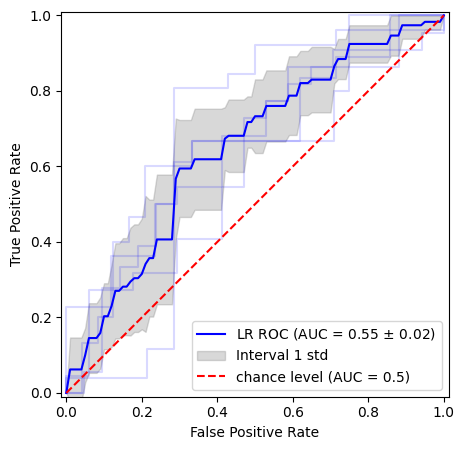

In [14]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

kf = KFold(5,shuffle=False)

tprs = []
base_fpr = np.linspace(0, 1, 101)

plt.figure(figsize=(5, 5))
plt.axes().set_aspect('equal', 'datalim')

for train, test in kf.split(X):
    model = LogisticRegression().fit(X[train], y[train])
    y_score = model.predict_proba(X[test])
    fpr, tpr, _ = roc_curve(y[test], y_score[:, 1])
    
    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std


plt.plot(base_fpr, mean_tprs, 'b', 
         label=r"LR ROC (AUC = %0.2f $\pm$ %0.2f)" % (cross_val_score(LogisticRegression(), X, y, scoring="roc_auc", cv=5).mean(),
                                                          cross_val_score(LogisticRegression(), X, y, scoring="roc_auc", cv=5).std()))
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3, label="Interval 1 std")

plt.plot([0, 1], [0, 1],'r--', label="chance level (AUC = 0.5)")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()

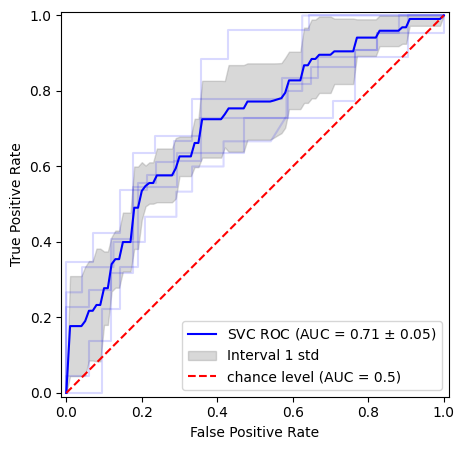

In [15]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

random.seed(42)

kf = KFold(5,shuffle=False)

tprs = []
base_fpr = np.linspace(0, 1, 101)

plt.figure(figsize=(5, 5))
plt.axes().set_aspect('equal', 'datalim')

for train, test in kf.split(X):
    model = SVC(probability=True).fit(X[train], y[train])
    y_score = model.predict_proba(X[test])
    fpr, tpr, _ = roc_curve(y[test], y_score[:, 1])
    
    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std


plt.plot(base_fpr, mean_tprs, 'b', 
         label=r"SVC ROC (AUC = %0.2f $\pm$ %0.2f)" % (cross_val_score(SVC(), X, y, scoring="roc_auc", cv=5).mean(),
                                                          cross_val_score(SVC(), X, y, scoring="roc_auc", cv=5).std()))
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3, label="Interval 1 std")

plt.plot([0, 1], [0, 1],'r--', label="chance level (AUC = 0.5)")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.show()

### Confusion matrix za porocilo (za zagon preskoci dajanje tabele v drugo obliko v poglavju grafi)

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

#confusion_matrix(y, SVC().fit(X, y).predict(X))
confusion_matrix(y, KNeighborsClassifier().fit(X, y).predict(X))

array([[59, 34],
       [21, 82]], dtype=int64)